<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [1]:
import sys
import os
from PIL import Image
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Dataset

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary
import datetime

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
trans_augmentation = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(10, fill=(0,)),torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  train_set_augmentation = torchvision.datasets.EMNIST(root=dataset_path, transform=trans_augmentation,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

train_loader_augmentation  = torch.utils.data.DataLoader(
                 dataset=train_set_augmentation,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print("load train_loader")
preload_train_data = list(enumerate(train_loader))
preload_train_data_argumentation = list(preload_train_data) + list(enumerate(train_loader_augmentation))
print("load test_loader")
preload_test_data = list(enumerate(test_loader))

CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set
load train_loader
load test_loader


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss,acc_result):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.plot(acc_result,label='accuracy')
  best_accuracy = np.amax(acc_result)
  best_epoch = np.argmax(acc_result)
  ax.annotate(f"\nBest Accuracy:{best_acc:.5f} at epoch {best_epoch}", 
              xy=(best_epoch, best_accuracy),
              color="blue",
              xytext=(0.2*len(acc_result), best_accuracy-0.2),
              arrowprops=dict(facecolor='blue', shrink=0.05),
              )
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()


# Define CNN

In [0]:
#CNN
class ConvolutioNeuralNetwork (torch.nn.Module):
    def __init__(self,dropout=0,batch_norm=False):
        super(ConvolutioNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_bn = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 500)
        self.final = nn.Linear(500, 62)
        self.dropout=dropout
        self.batch_norm = batch_norm
    def forward(self, x):
        x = F.dropout(x,p = self.dropout)
        x = F.relu(self.conv1(x))
        if self.batch_norm:
            x = self.conv1_bn(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout(x,p = self.dropout)        
        x = F.relu(self.conv2(x))
        if self.batch_norm:
            x = self.conv2_bn(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))
        x = self.final(x)
        return x
    @property
    def name(self):
        return f"CNN, Dropout: {self.dropout}, Batch Normalization: {self.batch_norm}"    

2020-04-11 02:58:23.953116
CNN, Dropout: 0, Batch Normalization: False original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.80638,1:0.83284,2:0.84189,3:0.84693,4:0.85076,5:0.85278,6:0.85471,7:0.85637,8:0.85721,9:0.85804,10:0.85909,11:0.85972,12:0.86002,13:0.86026,14:0.86078

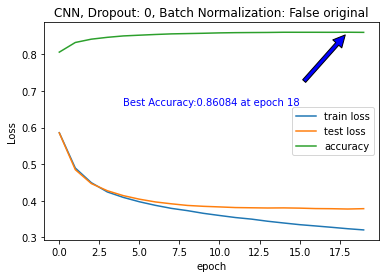

2020-04-11 03:03:27.804393
CNN, Dropout: 0, Batch Normalization: False argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.86039,1:0.86047,2:0.86053,3:0.86015,4:0.85989,5:0.85943,6:0.85920,7:0.85857,8:0.85839,9:0.85785,10:0.85759,11:0.85711,12:0.85682,13:0.85580,14:0.

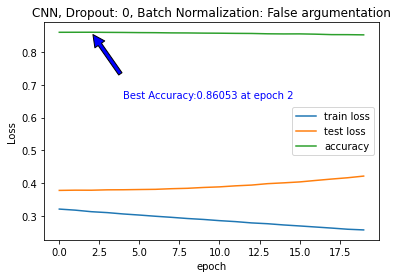

2020-04-11 03:08:21.889880
CNN, Dropout: 0.1, Batch Normalization: False original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.80267,1:0.82929,2:0.83937,3:0.84345,4:0.84683,5:0.85028,6:0.85144,7:0.85260,8:0.85438,9:0.85490,10:0.85555,11:0.85559,12:0.85637,13:0.85824,14:0.858

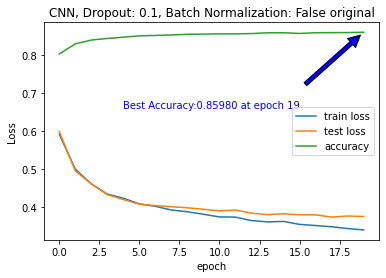

2020-04-11 03:13:21.300016
CNN, Dropout: 0.1, Batch Normalization: False argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.85948,1:0.85979,2:0.86025,3:0.85954,4:0.85952,5:0.86023,6:0.85938,7:0.86036,8:0.86037,9:0.86002,10:0.85966,11:0.85947,12:0.85992,13:0.86009,14:

KeyboardInterrupt: ignored

In [5]:
models = (
    ConvolutioNeuralNetwork(dropout = 0,batch_norm=False),
    ConvolutioNeuralNetwork(dropout = 0.1,batch_norm=False),    
    ConvolutioNeuralNetwork(dropout = 0.1,batch_norm=True),
    ConvolutioNeuralNetwork(dropout = 0.2,batch_norm=False),    
    ConvolutioNeuralNetwork(dropout = 0.2,batch_norm=True),     
    ConvolutioNeuralNetwork(dropout = 0.3,batch_norm=True),    
    ConvolutioNeuralNetwork(dropout = 0.4,batch_norm=True)     
)
train_data_list = (
    ("original", preload_train_data),
    ("argumentation",preload_train_data_argumentation)
)
sample_limit = 1000000
for model in models:
  for train_data_name,train_data in train_data_list:
    print(datetime.datetime.now())
    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    name = f'{model.name} {train_data_name}' 
    print(f'{name}')
    train_loss=[]
    test_loss=[]
    acc_result=[]  
    if use_cuda:
      model.cuda()
    model.to(torch.device("cuda"))
    summary(model,(1,28,28))
    best_acc = 0
    for epoch in range(20):
      # training
      ave_loss = 0
      for batch_idx, (x, target) in train_data:
          optimizer.zero_grad()
          if use_cuda:
              x, target = x.cuda(), target.cuda()
          out,loss = apply_model (model,x,target)
          ave_loss = ave_loss * 0.9 + loss.data* 0.1
          loss.backward()
          optimizer.step()
          if (batch_idx+1) == len(train_loader) or batch_idx >sample_limit:
              #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, train loss: {ave_loss:.6f}')
              break
      train_loss.append(ave_loss)
      # testing
      correct_cnt, ave_loss = 0, 0
      total_cnt = 0
      for batch_idx, (x, target) in preload_test_data:
          if use_cuda:
            x, target = x.cuda(), target.cuda()      
          out,loss = apply_model (model,x,target)        
          _, pred_label = torch.max(out.data, 1)
          total_cnt += x.data.size()[0]
          correct_cnt += (pred_label == target.data).sum()
          # smooth average
          ave_loss = ave_loss * 0.9 + loss.data * 0.1
          if (batch_idx) == len(test_loader)-1 or batch_idx >sample_limit:
              #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, test loss: {ave_loss:.6f}, acc: {correct_cnt * 1.0 / total_cnt:.3f}')
              break
      acc = correct_cnt * 1.0 / total_cnt
      print(f'{epoch}:{acc:.5f}', end=',')
      if (acc > best_acc):
        best_acc = acc
        best_epoch = epoch
      test_loss.append(ave_loss)
      acc_result.append(acc)
    print (f"\nBest Accuracy:{best_acc} at epoch {best_epoch}")  
    plot_graph(name,train_loss,test_loss,acc_result)
print("done")

#### Best Accuracy:0.8650997877120972 at epoch 6
#### Best Accuracy:0.8614203333854675 at epoch 9
#### Best Accuracy:0.8674553036689758 at epoch 9
#### Best Accuracy:0.8606036901473999 at epoch 13
#### Best Accuracy:0.864669919013977 at epoch 8
